In [3]:
import os
import itertools
from random import *
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.layers import Conv1D, Add,Concatenate,Bidirectional, GRU,Layer,  Attention

In [7]:
datasetnames = ["ALKBH5_Baltz2012","C17ORF85_Baltz2012","C22ORF28_Baltz2012","CAPRIN1_Baltz2012","CLIPSEQ_AGO2",
"CLIPSEQ_ELAVL1","CLIPSEQ_SFRS1","ICLIP_HNRNPC","ICLIP_TDP43","ICLIP_TIA1","ICLIP_TIAL1",
"PARCLIP_AGO1234","PARCLIP_ELAVL1","PARCLIP_ELAVL1A","PARCLIP_EWSR1","PARCLIP_FUS","PARCLIP_HUR",
"PARCLIP_IGF2BP123","PARCLIP_MOV10_Sievers","PARCLIP_PUM2","PARCLIP_QKI","PARCLIP_TAF15","PTBv1","ZC3H7B_Baltz2012"]

## Part1：Pre-training mask data processing

In [10]:
def readFa(fa):
    with open(fa,'r') as FA:
        seqName,seq,struct_seq='','',''
        while 1:
            line=FA.readline()
            line=line.strip('\n')
            if (line.startswith('>') or not line) and seqName:
                yield((seqName,seq,struct_seq))
            if line.startswith('>'):
                seqName = line[1:]
                seq=''
                struct_seq=''
            elif line.startswith('(') or line.startswith('.'):
                struct_seq+=line
            else:
                seq+=line
            if not line:break

In [11]:
#A function for k-mer lemmatising the data

def seq_to_kmer(sentence, kmer):
    
    ans = ''
    for i in range(0,len(sentence)-kmer+1):
        ans = ans + sentence[i:i+kmer] + ' '

    return ans

In [12]:
def init_seq_dictionary(kmer):

    ans = '[MASK] '
    nucleotide_list = ['a', 'u', 'c', 'g']
    temp = [''.join(x) for x in itertools.product(*[nucleotide_list] * kmer)]
    for i in temp:
        ans = ans + i + ' '

    return ans

In [13]:
def init_data_pre_training(kmer):
    # 1.Read pre-training data
    training_seq_positives = []
    training_seq_negatives = []
    training_labels = []

    for datasetname in datasetnames:
        # Read the positive example
        fa = "Your own address."
        for seqName, seq, struct_seq in readFa(fa):
            if len(seq) > 501:
                continue
            training_seq_positives.append(seq_to_kmer(seq, kmer))

        # Read the negative example
        fa = "Your own address."
        for seqName, seq, struct_seq in readFa(fa):
            if len(seq) > 501:
                continue
            training_seq_negatives.append(seq_to_kmer(seq, kmer))
        

    # 2.Initialising the splitter
    tokenizer_seq = Tokenizer()
    tokenizer_seq.fit_on_texts([init_seq_dictionary(kmer)])
    word_dict = tokenizer_seq.word_index
    number_dict = {i + 1: w for i, w in enumerate(word_dict)}

    # 3.Serialise statements using a disambiguator, words in non-disambiguators (subsequences with N) are not transformed
    training_seq_positives = tokenizer_seq.texts_to_sequences(training_seq_positives)
    training_seq_negatives = tokenizer_seq.texts_to_sequences(training_seq_negatives)

    # 4.Constructing masks (mask sequence, masked-off bits corresponding to values, masked-off positions)
    max_pred = 75  # Maximum number of words predicted
    vocab_size = len(word_dict) + 1
    maxlen = 500  # Length after sequence padding

    mask_sequence = []
    mask_tokens = []
    mask_pos = []

    # Constructing the Positive Case Mask
    for input_ids in training_seq_positives:
        # MASK LM
        n_pred = int(round(len(input_ids) * (0.15 / kmer)))
        cand_maked_pos = [i for i, token in enumerate(input_ids)]
        shuffle(cand_maked_pos)  
        array = cand_maked_pos[:n_pred]
        array.sort()

        masked_pos = []
        for i in range(n_pred - 1):
            flag = 0
            for j in range(kmer):
                if array[i] + j + 1 == array[i + 1]:
                    flag = 1
                    break
            if flag == 1:
                continue
            else:
                for j in range(kmer):
                    masked_pos.append(array[i] + j)

        masked_tokens = []
        for pos in masked_pos:
            masked_tokens.append(input_ids[pos])
            input_ids[pos] = word_dict['mask']  # make mask

        n_pad = maxlen - len(input_ids)
        input_ids.extend([0] * n_pad)

        n_pad = max_pred - len(masked_pos)
        masked_tokens.extend([0] * n_pad)
        masked_pos.extend([499] * n_pad)

        mask_sequence.append(input_ids)
        mask_tokens.append(masked_tokens)
        mask_pos.append(masked_pos)
        training_labels.append(1)

    # Negative examples do not perform MLM tasks
    for input_ids in training_seq_negatives:
        # MASK LM
        n_pred = int(round(len(input_ids) * (0.15 / kmer)))
        cand_maked_pos = [i for i, token in enumerate(input_ids)]
        shuffle(cand_maked_pos)
        array = cand_maked_pos[:n_pred]
        array.sort()
        position = []
        for i in range(n_pred - 1):
            flag = 0
            for j in range(kmer):
                if array[i] + j + 1 == array[i + 1]:
                    flag = 1
                    break
            if flag == 1:
                continue
            else:
                for j in range(kmer):
                    position.append(array[i] + j)

        for pos in position:
            input_ids[pos] = word_dict['mask']  # make mask

        masked_tokens = []
        masked_pos = []

        n_pad = maxlen - len(input_ids)
        input_ids.extend([0] * n_pad)

        masked_tokens.extend([0] * max_pred)
        masked_pos.extend([499] * max_pred)

        mask_sequence.append(input_ids)
        mask_tokens.append(masked_tokens)
        mask_pos.append(masked_pos)
        training_labels.append(0)

    # 6.Arrayed Lists
    mask_sequence = np.array(mask_sequence)
    mask_pos = np.array(mask_pos)
    mask_tokens = np.array(mask_tokens)
    labels = np.array(training_labels)


    return mask_sequence, mask_tokens, mask_pos, labels 

In [14]:
def init_data_fine_tuning(datasetname, kmer):
    # 1.Read the training set
    training_seq_positives = []
    training_labels_positives = []

    fa = "RBP-24/" + datasetname + ".train.positives.fa"
    for seqName, seq, struct_seq in readFa(fa):
        training_seq_positives.append(seq)
        training_labels_positives.append(1)

    training_seq_negatives = []
    training_labels_negatives = []

    fa = "RBP-24/" + datasetname + ".train.negatives.fa"
    for seqName, seq, struct_seq in readFa(fa):
        training_seq_negatives.append(seq)
        training_labels_negatives.append(0)

    training_seq = []
    training_labels = []

    while len(training_seq_positives) != 0:
        training_seq.append(training_seq_positives.pop())
        training_labels.append(training_labels_positives.pop())
        if len(training_seq_negatives) != 0:
            training_seq.append(training_seq_negatives.pop())
            training_labels.append(training_labels_negatives.pop())
    while len(training_seq_negatives) != 0:
        training_seq.append(training_seq_negatives.pop())
        training_labels.append(training_labels_negatives.pop())

    # 2.Read test set
    testing_seq_positives = []
    testing_labels_positives = []

    fa = "RBP-24/" + datasetname + ".ls.positives.fa"
    for seqName, seq, struct_seq in readFa(fa):
        testing_seq_positives.append(seq)
        testing_labels_positives.append(1)

    testing_seq_negatives = []
    testing_labels_negatives = []

    fa = "RBP-24/" + datasetname + ".ls.negatives.fa"
    for seqName, seq, struct_seq in readFa(fa):
        testing_seq_negatives.append(seq)
        testing_labels_negatives.append(0)

    testing_seq = []
    testing_labels = []

    while len(testing_seq_positives) != 0:
        testing_seq.append(testing_seq_positives.pop())
        testing_labels.append(testing_labels_positives.pop())
        if len(testing_seq_negatives) != 0:
            testing_seq.append(testing_seq_negatives.pop())
            testing_labels.append(testing_labels_negatives.pop())

    while len(testing_seq_negatives) != 0:
        testing_seq.append(testing_seq_negatives.pop())
        testing_labels.append(testing_labels_negatives.pop())

    # 3.Sequence data processing
    training_sequence = []

    for sentence in training_seq:
        temp = seq_to_kmer(sentence, kmer)
        training_sequence.append(temp)

    testing_sequence = []

    for sentence in testing_seq:
        temp = seq_to_kmer(sentence, kmer)
        testing_sequence.append(temp)

    # 4.Serialising statements using a splitter
    tokenizer_seq = Tokenizer()
    tokenizer_seq.fit_on_texts([init_seq_dictionary(kmer)])

    max_length_seq = 500
    trunc_type = 'post'
    padding_type = 'post'

    training_sequences = tokenizer_seq.texts_to_sequences(training_sequence)
    training_seq_padded = pad_sequences(training_sequences, maxlen=max_length_seq, padding=padding_type,
                                        truncating=trunc_type)

    testing_sequences = tokenizer_seq.texts_to_sequences(testing_sequence)
    testing_seq_padded = pad_sequences(testing_sequences, maxlen=max_length_seq, padding=padding_type,
                                       truncating=trunc_type)

    # 5.Arrayed Lists

    training_seq_padded = np.array(training_seq_padded)
    training_labels = np.array(training_labels)

    testing_seq_padded = np.array(testing_seq_padded)
    testing_labels = np.array(testing_labels)

    return training_seq_padded, training_labels, testing_seq_padded, testing_labels

In [15]:
def struct_to_seq(struct):
    ans = ''
    stack = []
    flag = 0

    for index in range(0,len(struct)):
        if struct[index] == '(':
            ans = ans + 'S'
            stack.append('(')
            flag = 0
        elif struct[index] == ')':
            ans = ans + 'S'
            stack.pop()
            flag = 1
        else:
            if len(stack) == 0:
                if struct.count('(',0,index) == 0 or struct.count(')',index,len(struct)) == 0:
                    ans = ans + 'F'
                else:
                    ans = ans + 'J'
            else:
                if flag == 1:
                    ans = ans + 'M'
                else:
                    for i in range(index, len(struct)):
                        if struct[i] == ')':
                            ans = ans + 'H'
                            break
                        elif struct[i] == '(':
                            ans = ans + 'M'
                            break

    return ans

In [16]:
#A function for k-mer lemmatising the data
def struct_to_kmer(sentence, kmer):
    
    ans = ''

    for i in range(0,len(sentence)-kmer+1):
        ans = ans + sentence[i:i+kmer] + ' '

    return ans

In [17]:
def init_struct_dictionary(kmer):

    ans = '[MASK] '
    nucleotide_list = ['f', 'h', 'j', 'm','s']
    temp = [''.join(x) for x in itertools.product(*[nucleotide_list] * kmer)]
    for i in temp:
        ans = ans + i + ' '

    return ans

In [ ]:
def get_key_from_value(dictionary, value):
    for key, val in dictionary.items():
        if val == value:
            return key
    return None  

In [ ]:
struct_tokenizer = Tokenizer.from_file("structBPE.json")
word_dict=struct_tokenizer.get_vocab()
dict_ans=''
input_struct_vocab_size=len(struct_tokenizer.get_vocab())
for i in range(1, len_vocab):
    result = get_key_from_value(word_dict, i)
    dict_ans = dict_ans + result + ' '
print(dict_ans)

In [18]:
def init_data_pre_training_only_struct(kmer):
    # 1.Read pre-training data
    training_struct_positives = []
    training_struct_negatives = []

    for datasetname in datasetnames:
        # Read the positive example
        fa = "Your own address."
        for seqName, seq, struct_seq in readFa(fa):
            if len(seq) > 501:
                continue
            index = seq.find("N")   
            struct_seq = struct_seq[:index]  
            struct_seq=struct_to_seq(struct_seq)
            training_struct_positives.append(struct_to_kmer(struct_seq, kmer))
            

        # Read the negative example
        fa = "Your own address."
        for seqName, seq, struct_seq in readFa(fa):
            if len(seq) > 501:
                continue
            training_struct_negatives.append([])                    

    # 2.Initialising the splitter
    tokenizer_struct = Tokenizer()
    tokenizer_struct.fit_on_texts([dict_ans])

    # 3.Serialise statements using a disambiguator, words in non-disambiguators (subsequences with N) are not transformed
    training_struct_positives = tokenizer_struct.texts_to_sequences(training_struct_positives)

    # 4 Constructing masks (mask sequence, masked-off bits corresponding to values, masked-off positions)
    maxlen = 500  # Length after sequence padding
    struce_pos=[]
    struct_ped=[]
    
    # Constructing the Positive Case Mask
    for input_ids in training_struct_positives:

        n_pad = maxlen - len(input_ids)
        input_ids.extend([0] * n_pad)
        
        struct_ped.append(input_ids)
        temp=list(range(500)) 
        struce_pos.append(temp)
        
    # Negative examples do not perform MLM tasks
    for input_ids in training_struct_negatives:

        n_pad = maxlen - len(input_ids)
        input_ids.extend([0] * n_pad)
        
        struct_ped.append(input_ids)
        struce_pos.append([499] * 500)
        

    # 6.Arrayed Lists
    struce_pos=np.array(struce_pos)
    struct_ped=np.array(struct_ped)

    return struct_ped, struce_pos

## Part2：Model Building Functions

In [20]:

def get_angles(pos, i, d_model):
    
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

### Masking

In [21]:
def create_padding_mask(seq):
    
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

### Scaled dot product attention 

In [22]:
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

### MultiHead Attention

In [23]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0
        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
       
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  
        k = self.wk(k)  
        v = self.wv(v)  

        q = self.split_heads(q, batch_size)  
        k = self.split_heads(k, batch_size)  
        v = self.split_heads(v, batch_size)  

        
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention,
                                        perm=[0, 2, 1, 3])  

        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))  

        output = self.dense(concat_attention)  

        return output, attention_weights

### Gelu activation function  

In [24]:
class GELU(tf.keras.layers.Layer):
    def __init__(self):
        super(GELU, self).__init__()

    def call(self, x):
        cdf = 0.5 * (1.0 + tf.tanh((np.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3)))))
        return x * cdf

In [25]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)

        self.dense1 = tf.keras.layers.Dense(dff)
        self.activation = GELU()
        self.dense2 = tf.keras.layers.Dense(d_model)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, mask):
        attn_output, _ = self.mha(x, x, x, mask)  
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(x + attn_output)  

        ffn_output = self.dense1(out1)  
        ffn_output = self.activation(ffn_output)
        ffn_output = self.dense2(ffn_output)  
        ffn_output = self.dropout2(ffn_output)
        out2 = self.layernorm2(out1 + ffn_output)  

        return out2

### Embedding

In [26]:
class Embedding(tf.keras.layers.Layer):
    def __init__(self, d_model, input_vocab_size, **kwargs):
        super(Embedding, self).__init__(**kwargs)
        self.d_model = d_model
        self.tok_embed = tf.keras.layers.Embedding(input_vocab_size, d_model, name='tok_embed')

    def call(self, x):
        x = self.tok_embed(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        return x

In [27]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, maxlen, rate=0.1, name='encoder'):
        super(Encoder, self).__init__(name=name)
        self.num_layers = num_layers

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                           for _ in range(num_layers)]

        self.pos_encoding = positional_encoding(maxlen, d_model)

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, mask):

        seq_len = tf.shape(x)[1]

        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, mask)

        return x  

In [28]:
def gather_indexes(input, positions):
    """Gathers the vectors at the specific positions over a minibatch."""
    sequence_shape = tf.shape(input)
    batch_size = sequence_shape[0]
    seq_len = sequence_shape[1]
    d_model = sequence_shape[2]

    flat_offsets = tf.reshape(tf.range(0, batch_size, dtype=tf.int32) * seq_len, [-1, 1])
    flat_positions = tf.reshape(positions + flat_offsets, [-1])
    flat_input_tensor = tf.reshape(input, [batch_size * seq_len, d_model])
    output_tensor = tf.gather(flat_input_tensor, flat_positions)
    output_tensor = tf.reshape(output_tensor, [batch_size, -1, d_model])

    return output_tensor 

In [29]:
class MaskedLanguageModel(tf.keras.layers.Layer):
    def __init__(self, d_model, input_vocab_size, name):
        super(MaskedLanguageModel, self).__init__()
        self._name = name

        self.dense = tf.keras.layers.Dense(d_model)
        self.activation1 = GELU()
        self.layernorm = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.decoder = tf.keras.layers.Dense(input_vocab_size, use_bias=False)

        b_init = tf.zeros_initializer()(shape=(input_vocab_size,), dtype="float32")
        self.bias = tf.Variable(initial_value=b_init, trainable=True)

        self.activation2 = tf.keras.layers.Activation(activation="softmax")

    def call(self, x, positions):
        # x: (batch_size, input_seq_len, d_model)
        # positions: (batch_size, max_pred)

        mask_inputs = gather_indexes(x, positions) # (batch_size, max_pred, d_model)

        mask_inputs = self.dense(mask_inputs) # (batch_size, max_pred, d_model)
        mask_inputs = self.activation1(mask_inputs)
        mask_inputs = self.layernorm(mask_inputs)

        out = self.decoder(mask_inputs) + self.bias # (batch_size, max_pred, input_vocab_size)

        out = self.activation2(out)

        return out # (batch_size, max_pred, input_vocab_size)

### Output Layer

In [30]:
class OutputLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, rate, name):
        super(OutputLayer, self).__init__()
        self._name = name

        self.flatten = tf.keras.layers.Flatten()
        self.dropout = tf.keras.layers.Dropout(rate)
        self.dense1 = tf.keras.layers.Dense(d_model, activation='tanh')
        self.dense2 = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, x):
        
        x = self.dense1(x)  
        x = self.flatten(x)  

        x = self.dropout(x)
        x = self.dense2(x)  

        return x  

In [ ]:
class SeqToStructModel(tf.keras.layers.Layer):
    def __init__(self, d_model, input_vocab_size, name):
        super(SeqToStructModel, self).__init__()
        self._name = name

        self.dense = tf.keras.layers.Dense(d_model)
        self.activation1 = GELU()
        self.layernorm = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.decoder = tf.keras.layers.Dense(input_vocab_size, use_bias=False)

        b_init = tf.zeros_initializer()(shape=(input_vocab_size,), dtype="float32")
        self.bias = tf.Variable(initial_value=b_init, trainable=True)

        self.activation2 = tf.keras.layers.Activation(activation="softmax")
        
    def call(self, x, positions):
        

        mask_inputs = gather_indexes(x, positions) 

        mask_inputs = self.dense(mask_inputs) 
        mask_inputs = self.activation1(mask_inputs)
        mask_inputs = self.layernorm(mask_inputs)

        out = self.decoder(mask_inputs) + self.bias 

        out = self.activation2(out)

        return out 

### Optimizer

In [31]:
#Define the variable learning rate formula
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

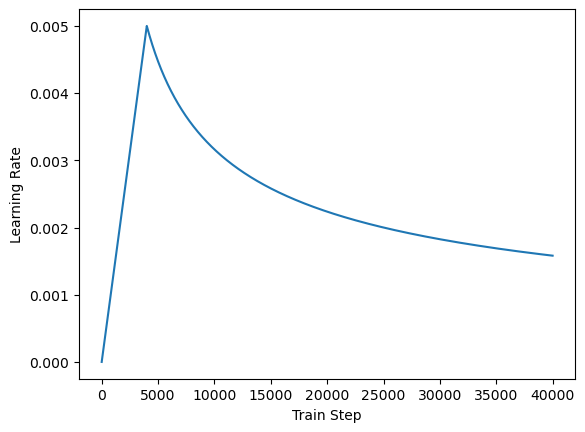

In [32]:
#Plotting learning rate change curves
import matplotlib.pyplot as plt

temp_learning_rate_schedule = CustomSchedule(d_model = 10)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")
plt.show()

## Part3：pre-training Step 1: Train  MLM and BFP pre-training tasks

In [34]:
kmer=4
input_vocab_size = 4**kmer + 2 
maxlen = 500
max_pred = 75

num_layers=6
d_model=16
num_heads=2
dff=5
rate=0.1

In [ ]:
# Getting pre-trained data
mask_sequence, mask_tokens, mask_pos, labels = init_data_pre_training(kmer)

In [ ]:
sequence = tf.keras.layers.Input(shape=(maxlen,), name="input_mask_sequence")
pos = tf.keras.layers.Input(shape=(max_pred,), dtype=tf.int32, name="input_mask_pos")
mask = create_padding_mask(sequence)

# Embedding
x = Embedding(d_model=d_model, input_vocab_size=input_vocab_size)(sequence)
# Encoder
bert_output = Encoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff, maxlen=maxlen, rate=rate)(x, mask)
# MLM  TASK
mlm_output = MaskedLanguageModel(d_model=d_model, input_vocab_size=input_vocab_size, name="mlm")(bert_output, pos)
# BFP TASK 
x = Bidirectional(GRU(16, dropout=0.2, return_sequences=True), name="bi-gru")(bert_output)
BFP_output = OutputLayer(d_model=d_model, rate=rate, name ="rpi")(x)

# BERT-Net
model = tf.keras.models.Model(inputs=[sequence, pos], outputs=[mlm_output, BFP_output])
model.summary()

learning_rate = CustomSchedule(d_model=d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-6)
model.compile(loss={'mlm': 'sparse_categorical_crossentropy', 'rpi': 'mean_squared_error'}, loss_weights={'mlm': 1, 'rpi': 1},optimizer=optimizer)

In [ ]:
num_epochs = 10000
mini_batches = 128

earlystop = tf.keras.callbacks.EarlyStopping(monitor = 'rpi_loss', mode='min', min_delta = 0, patience = 1, verbose = 1)
history = model.fit([mask_sequence, mask_pos], [mask_tokens, labels], batch_size = mini_batches, epochs=num_epochs, callbacks = earlystop, verbose=1)

In [46]:
# Initialization saves model parameters
checkpoint_path = "Your own address."
ckpt = tf.train.Checkpoint(model=model)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
ckpt_save_path = ckpt_manager.save()
print ('Saving checkpoint at {}'.format(ckpt_save_path))

## Part4：pre-training Step 2: Train MLM, BFP and SSC pre-training tasks

In [49]:
# Getting pre-trained data
mask_sequence, mask_tokens, mask_pos, labels = init_data_pre_training(kmer)
struct_ped, struct_pos = init_data_pre_training_only_struct(kmer)

In [50]:
sequence = tf.keras.layers.Input(shape=(maxlen,), name="input_mask_sequence")
pos = tf.keras.layers.Input(shape=(max_pred,), dtype=tf.int32, name="input_mask_pos")
pos_struct= tf.keras.layers.Input(shape=(maxlen,), dtype=tf.int32, name="input_struct_pos")
mask = create_padding_mask(sequence)

# Embedding
x = Embedding(d_model=d_model, input_vocab_size=input_vocab_size, name='embedding')(sequence)
# Encoder
bert_output = Encoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff, maxlen=maxlen, rate=rate,name='encoder')(x, mask)
# MLM  TASK
mlm_output = MaskedLanguageModel(d_model=d_model, input_vocab_size=input_vocab_size, name="mlm")(bert_output, pos)
# BFP TASK     
x = Bidirectional(GRU(16, dropout=0.2, return_sequences=True), name="bi-gru")(bert_output)
BFP_output = OutputLayer(d_model=d_model, rate=rate, name ="rpi")(x)
#SSC TASK 
seq_to_struct_output = SeqToStructModel(d_model=d_model, input_vocab_size=input_struct_vocab_size, name="rna_structure")(bert_output,pos_struct)

# BERT-Net
model = tf.keras.models.Model(inputs=[sequence, pos, pos_struct], outputs=[mlm_output,BFP_output,seq_to_struct_output])
model.summary()

learning_rate = CustomSchedule(d_model=d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-6)
model.compile(loss={'mlm': 'sparse_categorical_crossentropy','rna_structure':'sparse_categorical_crossentropy',  'rpi': 'mean_squared_error'}, loss_weights={'mlm': 1, 'rpi': 1,'rna_structure':1 },optimizer=optimizer)

In [51]:
# Load pre-training weights
checkpoint_path="Your own address."
ckpt = tf.train.Checkpoint(model=model)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
ckpt.restore(ckpt_manager.latest_checkpoint)

In [ ]:
num_epochs = 10000
mini_batches = 128

earlystop = tf.keras.callbacks.EarlyStopping(monitor = 'rpi_loss', mode='min', min_delta = 0, patience = 1, verbose = 1)
history = model.fit([mask_sequence, mask_pos, struct_pos], [mask_tokens, labels, struct_ped], batch_size = mini_batches, epochs=num_epochs, callbacks = earlystop, verbose=1)

In [ ]:
# Save bert_model model
bert_model = tf.keras.models.Model(inputs=sequence, outputs=BFP_output)
bert_model.save_weights("Your own address.")

## Part5：fine tuning

In [35]:
input_vocab_size = 4**kmer + 2 
maxlen = 500

num_layers=6
d_model=16
num_heads=2
dff=5
rate=0.1

In [ ]:
for datasetname in datasetnames:
    
    training_seq, training_labels, testing_seq, testing_labels = init_data_fine_tuning(datasetname=datasetname,kmer=kmer)
    
    sequence = tf.keras.layers.Input(shape=(maxlen,), name="input_mask_sequence")
    mask = create_padding_mask(sequence) 
    # Embedding
    x = Embedding(d_model=d_model, input_vocab_size=input_vocab_size, name='embedding_fine')(sequence)
    # Encoder
    x = Encoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff, maxlen=maxlen, rate=rate,name='encoder_fine')(x, mask)
    # BFP TASK
    x = Bidirectional(GRU(16, dropout=0.2, return_sequences=True), name="bi-gru")(x)
    BFP_output = OutputLayer(d_model=d_model, rate=rate, name ="rpi")(x)

    # BERT-Net
    model = tf.keras.models.Model(inputs=sequence, outputs=BFP_output)
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    # Initialize model parameters
    model.load_weights("Your own address.")
    
    # Define the model save path
    save_directory = "Your own address."
    os.makedirs(save_directory, exist_ok=True)
    checkpoint_path = save_directory+"/best_model.h5"
    
    ckpt = tf.train.Checkpoint(model=model)
    ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=8)    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)
    
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor="val_loss",  
        save_best_only=True,  
        save_weights_only=True,  
        verbose=0
    )
    
    num_epochs = 50
    mini_batches = 128
    history = model.fit(
        training_seq, 
        training_labels, 
        batch_size=mini_batches, 
        epochs=num_epochs, 
        verbose=1, 
        validation_data=(testing_seq, testing_labels), 
        callbacks=[checkpoint,early_stopping]
    )
    


## Part6：Evaluation of fine-tuning results

In [ ]:
sequence = tf.keras.layers.Input(shape=(maxlen,), name="input_mask_sequence")
mask = create_padding_mask(sequence) 
# Embedding
x = Embedding(d_model=d_model, input_vocab_size=input_vocab_size, name='embedding_fine')(sequence)
# Encoder
x = Encoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff, maxlen=maxlen, rate=rate,name='encoder_fine')(x, mask)
# BFP TASK
x = Bidirectional(GRU(16, dropout=0.2, return_sequences=True), name="bi-gru")(x)
BFP_output = OutputLayer(d_model=d_model, rate=rate, name ="rpi")(x)

# BERT-Net
model = tf.keras.models.Model(inputs=sequence, outputs=BFP_output)
model.summary()
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
for datasetname in datasetnames:
    print("dataset:",datasetname)
    
    training_seq, training_labels, testing_seq, testing_labels = init_data_fine_tuning(datasetname=datasetname,kmer=kmer)
    
    checkpoint_path = "Your own address."    
    model.load_weights(checkpoint_path)
        
    BFP_output = model.predict(x=testing_seq)

    auc = roc_auc_score(testing_labels, BFP_output)
    auc=round(auc, 3)
    print("AUC =", auc)
    

    ap = average_precision_score(testing_labels, BFP_output)
    ap=round(ap, 3)
    print("AP =", ap)
    